In [6]:
import numpy as np 
import pandas as pd

import os
print(os.listdir("../input"))

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras import layers
from keras.layers import Dense, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sb

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
# load in data
iowa_file_path = '../input/train.csv'
home_data = pd.read_csv(iowa_file_path)

# Create target object and call it y
y = home_data.SalePrice

# Create X
X = home_data.drop(['SalePrice'], axis=1)
X = X.select_dtypes(exclude=['object'])

# see which columns are missing data
cols_with_missing = (col for col in X.columns if X[col].isnull().any())

for col in cols_with_missing:
    X[col + '_was_missing'] = X[col].isnull()

# Imputation
features = X.columns
my_imputer = SimpleImputer()
X = my_imputer.fit_transform(X)

# scale the data 
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

# reshape for rnn
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))


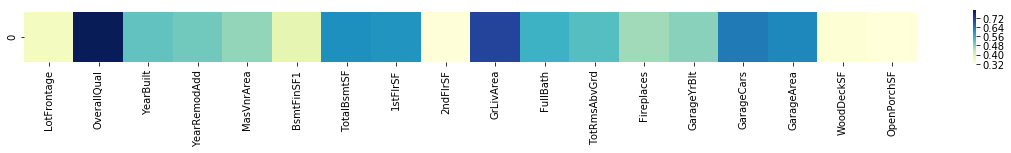

In [7]:
# look at heat map of features against house_prices
C_mat = home_data.drop(columns=['Id']).corr()
fig = plt.figure(figsize = (20,1))
sales_corr = pd.DataFrame()
for name in C_mat.columns:
    to_add = np.absolute([C_mat[name][36]])
    if to_add[0] > 0.3 and name != 'SalePrice':
        sales_corr[name] = [C_mat[name][36]]

sb.heatmap(sales_corr, square = True, cmap="YlGnBu")


In [ ]:
# define base model
def baseline_model():
    
    model = Sequential()

    model.add(LSTM(128, input_shape=((1, 40)), activation='linear', return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(256, activation='linear'))
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation='linear'))
    model.add(Dense(128, activation='linear'))
    model.add(Dense(64, activation='linear'))
    model.add(Dense(32, activation='linear'))   
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mae', optimizer='adam', metrics=['mean_absolute_error'])


    return model


# fix random seed
seed = 7
np.random.seed(seed)

# build model
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=80, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)

# test with kfold validation
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Standardized: %.2f (%.2f) MAE" % (results.mean(), results.std()))

In [ ]:

# fit rf_model_on_full_data on all data from the 
pipeline.fit(X, y)

# path to file you will use for predictions
test_data_path = '../input/test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path)

cols_with_missing = (col for col in test_data.columns if test_data[col].isnull().any())

for col in cols_with_missing:
    test_data[col + '_was_missing'] = test_data[col].isnull()

# create test_X which comes from test_data but includes only the columns you used for prediction.
# The list of columns is stored in a variable called features
test_X = test_data[features]


# my_imputer = SimpleImputer()
test_X = my_imputer.transform(test_X)

test_X = min_max_scaler.transform(test_X)

test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))


# make predictions
preds = pipeline.predict(test_X)

# write to csv
output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': preds})

output.to_csv('submission.csv', index=False)
